1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn import model_selection

In [2]:
data, labels = datasets.make_classification(
    n_samples=1000,
    n_features=2,
    n_classes=2,
    n_informative=2,
    n_clusters_per_class=1,
    n_redundant=0,
    random_state=42
)

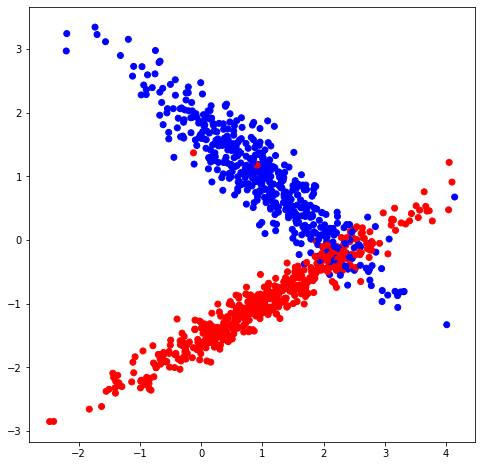

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(
    data[:,0], 
    data[:,1],
    c=labels,
    cmap=colors
)
plt.show()

##### Загружаем все необходимые функции

In [4]:
def get_bootstrap(data, labels, N):
    
    random.seed(42)
    
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [8]:
def entropy(labels):
    '''расчет критерия энтропии'''
    
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label]=0
        classes[label]+=1
        
    p = []
    for label in classes:
        p.append(classes[label] / len(labels))

    p = np.array(p)
    
    return -(p*np.log2(p)).sum()

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
        
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

##### Разбиваем выборки на test и train

In [17]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    data, 
    labels, 
    test_size = 0.3,
    random_state = 1
)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

##### Строим лесa

In [19]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [20]:
def graphs(data):

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], data[0][0])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={data[1]}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={data[2]}')

In [21]:
def result(train_data, train_labels, n_trees):

    my_forest = random_forest(train_data, train_labels, n_trees)

    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, train_data)

    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    
    return my_forest, train_accuracy, test_accuracy

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Предскажем значения для __1го дерева__

Точность случайного леса из 1 деревьев на обучающей выборке: 95.429
Точность случайного леса из 1 деревьев на тестовой выборке: 87.667


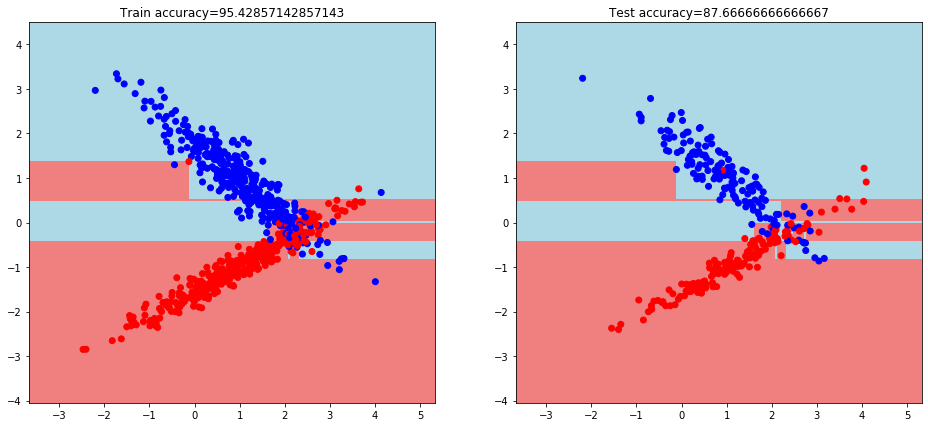

In [22]:
my_forest_1 = result(
    train_data=train_data,
    train_labels=train_labels,
    n_trees=1
)

graphs(my_forest_1)

Пока не ясно на сколько это сложная гиперплоскость

Простмотрим какие результаты будут у __3х деревьев__

Точность случайного леса из 3 деревьев на обучающей выборке: 98.143
Точность случайного леса из 3 деревьев на тестовой выборке: 89.333


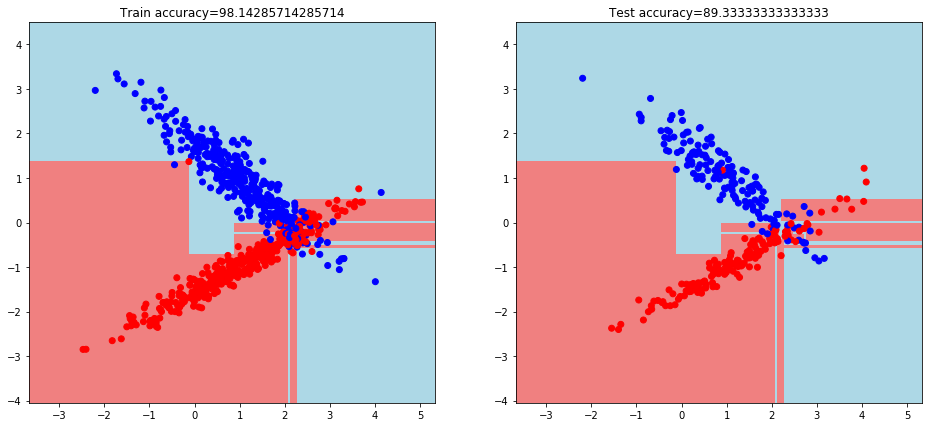

In [23]:
my_forest_3 = result(
    train_data=train_data,
    train_labels=train_labels,
    n_trees=3
)

graphs(my_forest_3)

__Точность__ предсказания на тесте __увеличилась__, но не так высоко как при Джини, гиперплоскость незколько __усложнилась__ - появилось больше вертикальных координал

Простмотрим какие результаты будут у __10 деревьев__

Точность случайного леса из 10 деревьев на обучающей выборке: 98.857
Точность случайного леса из 10 деревьев на тестовой выборке: 93.333


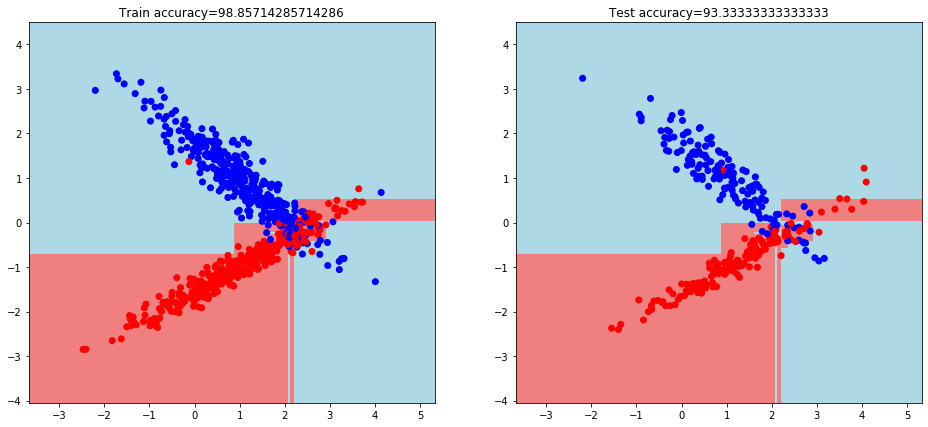

In [24]:
my_forest_10 = result(
    train_data=train_data,
    train_labels=train_labels,
    n_trees=10
)

graphs(my_forest_10)

Пока что __точность увеличивается__, хотя уже и не так __сильно__, разделение гиперплоскостей стала чаще __пересекать массу__ точек

Простмотрим какие результаты будут у __50 деревьев__

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 93.667


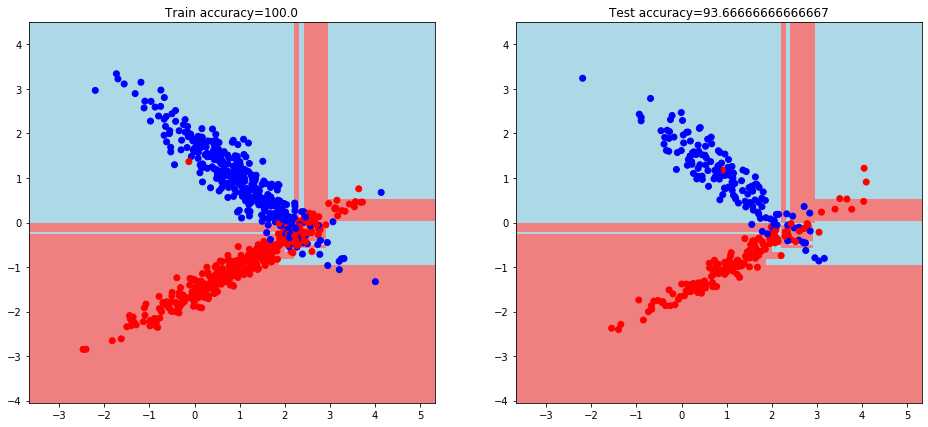

In [25]:
my_forest_50 = result(
    train_data=train_data,
    train_labels=train_labels,
    n_trees=50
)

graphs(my_forest_50)

Модель сообщает, что предсказывается __трейновую__ выборку с точностью __до 100%__, хотя видно на графиках, что это не так.<br>
Точность на __тестовой__ выборке __не увеливилась__, при этов обучение занимало __больше времени__ по сравнению с предыдушим тестом.<br>
Гиперплоскость начала __дробиться__ на прямоукольники

Простмотрим какие результаты будут у __100 деревьев__.

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 94.667


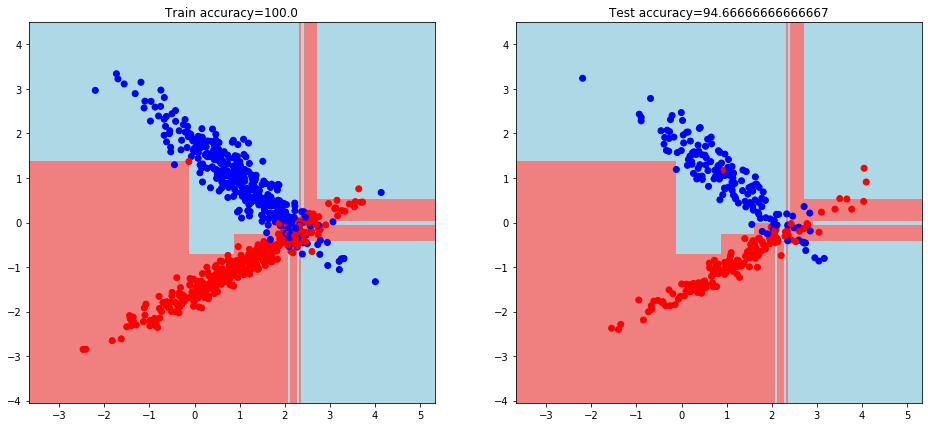

In [26]:
my_forest_100 = result(
    train_data=train_data,
    train_labels=train_labels,
    n_trees=100
)

graphs(my_forest_100)

__Трейновая__ выборка предсказывается моделью так же высоко, однако теперь удалось __увеличить__ точность предсказания __тестовой__ выборки.<br>
__Гиперплоскость__ стала еще чаще принимать __вертикальные__ коодинаты.

Простмотрим какие результаты будут у __200 деревьев__.

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000
Точность случайного леса из 200 деревьев на тестовой выборке: 94.333


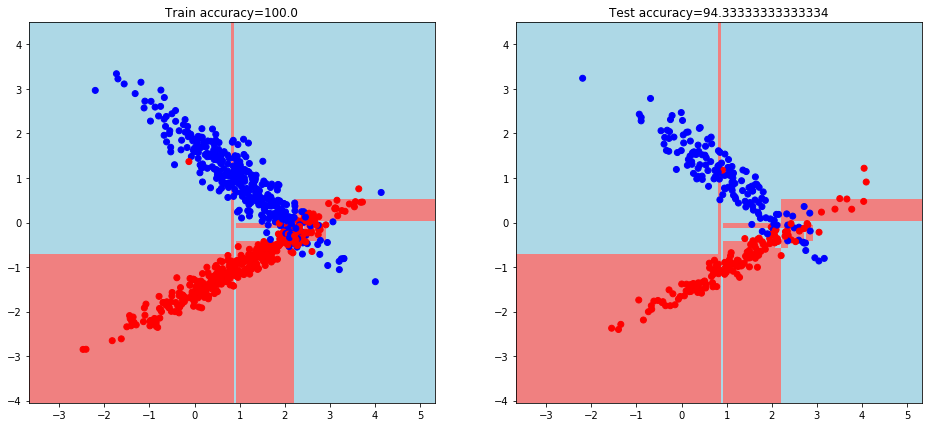

In [27]:
my_forest_200 = result(
    train_data=train_data,
    train_labels=train_labels,
    n_trees=200
)

graphs(my_forest_200)

Точность предсказания __тестовой__ выборки __упала__ по сравнению с предыддущим результатом.<br>
__Гиперплоскость__ перестала соприкасаться с единичными эллементами, с другой стороны она начала пересекать те участки, где нету подходящих сначений. Возможно это может говорить о __незначительном переобучении__, можно проверить.

Простмотрим какие результаты будут у __300 деревьев__.

Точность случайного леса из 300 деревьев на обучающей выборке: 100.000
Точность случайного леса из 300 деревьев на тестовой выборке: 94.000


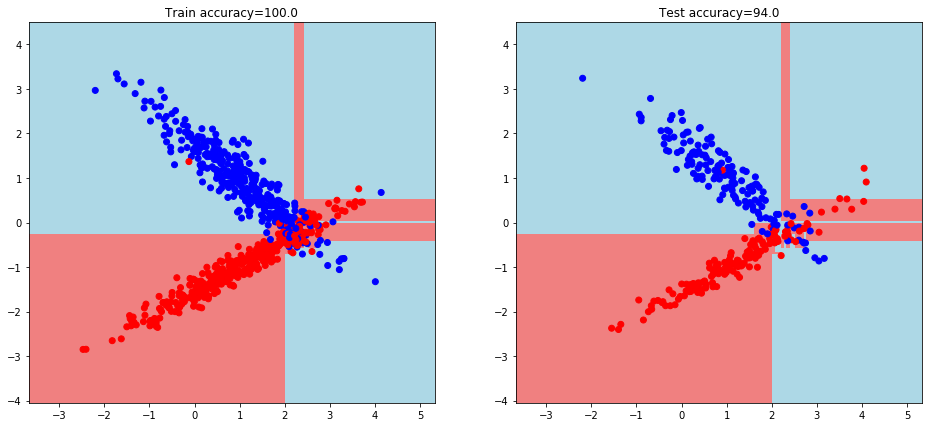

In [28]:
my_forest_300 = result(
    train_data=train_data,
    train_labels=train_labels,
    n_trees=300
)

graphs(my_forest_300)

Точность модели на __тестовой__ выборке снова __увеличилась__, при этом __гиперплоскости__ выглядят адекватно.<br>
Гипотеза о переобучении модели не подтверждена.

К тому же __94%__ точности является __средней__ точностью модели (минимальная 93.6% - началась при 10 деревьев, максимальная 94.3% - появлялась при 100 деревьев, остальные варианты колебались в этом промежутке).

В челом графики у энтропии несколько отличаются от графиков у Джини, но не сильно